In [1]:
import os
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score

We want to build a LASSO (or an elastic net) model with AAindex1 inputs (averaged over the 5 residues) as input and binding free energies for ACT and FEN as output predictions. This should tell us how important each physicochemical property is.

Also we want to measure how accurate the GP is in predicting __training__ data and data it hasn't seen. We can then compare what's what

In [2]:
def load_json_res(pcc, data_dir):
    with open(f"{data_dir}/{pcc}_FEN.JSON") as f:
        rep = json.load(f)
    F_fen = rep["FE"]
    F_fen_err = rep["FE_error"]

    with open(f"{data_dir}/{pcc}_DEC.JSON") as f:
        rep = json.load(f)
    F_dec = rep["FE"]
    F_dec_err = rep["FE_error"]
    return {"PCC": [rep["PCC"]], "F_FEN": [float(F_fen)], "err_FEN": [float(F_fen_err)],
             "F_DEC": [float(F_dec)], "err_DEC": [float(F_dec_err)]}

def load_data(data_dir):
    PCC_list = []
    for folder in os.listdir(data_dir):
        if re.match("[A-Z]{5}_[A-Z]{3}", folder):
            PCC_list.append(folder.split("_")[0])

    PCC_list = set(PCC_list)
    data = []
    for pcc in PCC_list:
        try:
            data.append(pd.DataFrame(load_json_res(pcc, data_dir)))
        except:
            print(f"Skipping {pcc}.")

    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    return data

In [3]:
dataset = load_data("../MD_results")
AAindex1 = pd.read_csv("./AAindex1.csv", index_col=0)

In [4]:
lasso_data = {"PCC": []}
for pp in AAindex1.property:
    lasso_data[pp] = []

In [5]:
for pcc in dataset.PCC:
    lasso_data["PCC"].append(pcc)
    for pp in AAindex1.property:
        pps = []
        for aa in pcc:
            pps.append(AAindex1[AAindex1.property == pp][aa].values[0])
        nancnt = np.count_nonzero(np.isnan(pps))
        if nancnt == 5:
            lasso_data[pp].append(0.0)
        else:
            lasso_data[pp].append(np.nanmean(pps))

In [6]:
lasso_data = pd.DataFrame(lasso_data)
lasso_data.head(10)

,PCC,alpha-CH chemical shifts,Hydrophobicity index,Signal sequence helical potential,Membrane-buried preference parameters,Conformational parameter of inner helix,Conformational parameter of beta-structure,Conformational parameter of beta-turn,Average flexibility indices,Residue volume,...,Weighted domination number using the atomic number,Average weighted eccentricity based on the the atomic number,Weighted radius based on the atomic number,Weighted diameter based on the atomic number,Total weighted atomic number of the graph,Average weighted atomic number or degree based on atomic number in the graph,Weighted maximum eigenvalue based on the atomic numbers,Weighted minimum eigenvalue based on the atomic numbers,Weighted average eigenvalue based on the atomic numbers,Weighted second smallest eigenvalue of the weighted Laplacian matrix
0,YGVWW,4.384,1.714,0.700,0.920,0.614,0.800,0.824,0.3920,101.68,...,14.6,19.356,12.6,25.6,44.6014,5.4108,23.7616,-0.1076,10.0444,2.3374
1,ASGWA,4.374,0.798,0.918,1.126,0.686,0.702,0.704,0.4140,66.36,...,8.6,11.266,7.8,14.8,24.2000,5.6994,16.1556,0.0422,7.3834,1.6088
2,GGAGN,4.202,0.176,0.576,0.738,0.480,0.654,0.850,0.4904,47.44,...,4.2,6.600,4.6,8.8,13.2014,4.6200,12.1416,0.0000,5.3000,0.6000
3,FWTWW,4.622,2.004,1.022,1.236,0.646,0.824,0.838,0.3346,118.26,...,19.2,23.630,16.0,29.2,55.8000,5.6802,28.0292,-0.7188,11.8500,2.8316
4,HWWWA,4.616,1.834,0.760,1.018,0.758,0.782,0.806,0.3190,110.14,...,18.6,22.320,15.6,29.0,52.6000,5.5402,25.1154,-0.2202,10.9300,1.5474
5,HYGWW,4.520,1.572,0.546,0.750,0.570,0.770,0.900,0.3794,103.04,...,16.4,21.876,15.0,29.4,49.2000,5.1508,23.8102,-0.4544,10.3244,1.4584
6,GGAGD,4.204,0.256,0.540,0.712,0.498,0.674,0.850,0.5000,45.98,...,4.2,6.580,4.2,8.8,13.4000,4.6600,12.3268,0.0000,5.3800,0.5938
7,HETSV,4.344,0.500,0.662,0.676,0.588,0.748,0.648,0.4314,77.56,...,9.0,16.066,10.8,20.6,32.0014,6.0200,24.1586,-1.1922,9.5468,4.2854
8,YADAL,4.446,1.018,1.206,1.374,0.776,0.770,0.616,0.4020,78.36,...,10.8,14.356,11.2,17.6,28.8000,6.2040,21.1814,-0.1920,8.8444,1.5362
9,FTYWD,4.614,1.412,0.802,0.968,0.530,0.812,0.812,0.3988,101.02,...,15.6,21.466,15.2,26.4,46.6000,6.0174,27.4952,-0.9952,11.2744,2.9276


In [7]:
std_df = lasso_data.drop(columns=["PCC"]).std()
low_std_cols = std_df[std_df.values < 0.01].index.values

In [8]:
lasso_data = lasso_data.loc[:, [i for i in lasso_data.columns if i not in low_std_cols]]

In [9]:
lasso_data

,PCC,alpha-CH chemical shifts,Hydrophobicity index,Signal sequence helical potential,Membrane-buried preference parameters,Conformational parameter of inner helix,Conformational parameter of beta-structure,Conformational parameter of beta-turn,Average flexibility indices,Residue volume,...,Weighted domination number using the atomic number,Average weighted eccentricity based on the the atomic number,Weighted radius based on the atomic number,Weighted diameter based on the atomic number,Total weighted atomic number of the graph,Average weighted atomic number or degree based on atomic number in the graph,Weighted maximum eigenvalue based on the atomic numbers,Weighted minimum eigenvalue based on the atomic numbers,Weighted average eigenvalue based on the atomic numbers,Weighted second smallest eigenvalue of the weighted Laplacian matrix
0,YGVWW,4.384,1.714,0.700,0.920,0.614,0.800,0.824,0.3920,101.68,...,14.6,19.3560,12.6,25.6,44.6014,5.4108,23.7616,-0.1076,10.0444,2.3374
1,ASGWA,4.374,0.798,0.918,1.126,0.686,0.702,0.704,0.4140,66.36,...,8.6,11.2660,7.8,14.8,24.2000,5.6994,16.1556,0.0422,7.3834,1.6088
2,GGAGN,4.202,0.176,0.576,0.738,0.480,0.654,0.850,0.4904,47.44,...,4.2,6.6000,4.6,8.8,13.2014,4.6200,12.1416,0.0000,5.3000,0.6000
3,FWTWW,4.622,2.004,1.022,1.236,0.646,0.824,0.838,0.3346,118.26,...,19.2,23.6300,16.0,29.2,55.8000,5.6802,28.0292,-0.7188,11.8500,2.8316
4,HWWWA,4.616,1.834,0.760,1.018,0.758,0.782,0.806,0.3190,110.14,...,18.6,22.3200,15.6,29.0,52.6000,5.5402,25.1154,-0.2202,10.9300,1.5474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NRPAY,4.504,1.020,0.552,0.744,0.474,0.684,0.798,0.4556,85.44,...,13.4,18.7448,14.4,22.8,34.0014,5.9640,23.0606,-0.1920,10.1778,4.1598
146,PGWWW,4.502,1.994,0.712,0.924,0.520,0.702,0.970,0.3936,103.22,...,17.0,19.6000,13.4,25.2,47.0000,5.3002,24.0668,0.1266,10.7500,3.6264
147,HETSK,4.426,0.466,0.458,0.478,0.544,0.662,0.724,0.4474,81.56,...,10.2,18.8660,13.2,24.4,34.6000,6.0540,23.9064,-1.2280,9.7802,3.3598
148,HWWLY,4.560,1.864,1.094,1.212,0.700,0.806,0.812,0.3436,116.18,...,18.6,24.2960,17.2,31.8,53.8000,5.6508,27.4144,-0.4544,11.5444,2.0810


In [10]:
corr_mat = lasso_data.drop(columns=["PCC"]).corr(method="spearman")

Low variance features (\<0.05) dropped

In [11]:
len(lasso_data.columns)-1

515

In [12]:
lasso_data_raw = lasso_data.copy()
# Calculate the correlation matrix
corr_mat = lasso_data.drop(columns=["PCC"]).corr(method="spearman")
threshold = 0.70  # Correlation threshold

to_keep = []
to_remove = []
bags = {}

while (len(to_keep) + len(to_remove))!= (len(lasso_data.columns)-1):
    curr_to_remove = []
    curr_col = corr_mat.columns[0]
    curr_vals = corr_mat[curr_col][1:]
    for i, val in enumerate(curr_vals):
        if abs(val) >= threshold:
            curr_to_remove.append(corr_mat.columns[i+1])
    to_keep.append(curr_col)
    to_remove.extend(curr_to_remove)
    bags[curr_col] = curr_to_remove
    corr_mat = lasso_data.drop(columns=["PCC"]+to_keep+to_remove).corr(method="spearman")

lasso_data = lasso_data[["PCC"] + to_keep]

In [13]:
bags_text = []
for key, values in bags.items():
    bags_text.append(f"* {key}:\n")
    if len(values) != 0:
        for val in values:
            bags_text.append(f"\t{val}\n")
    else:
        bags_text.append(f"\t\n")

with open("desc_bags.txt", "w") as f:
    f.writelines(bags_text)

In [14]:
lasso_data

,PCC,alpha-CH chemical shifts,Signal sequence helical potential,Conformational parameter of inner helix,Conformational parameter of beta-structure,Conformational parameter of beta-turn,Retention coefficient in TFA,alpha-NH chemical shifts,Normalized frequency of extended structure,A parameter defined from the residuals obtained from the best correlation of,...,Principal property value z3,"Normalized positional residue frequency at helix termini N""",Normalized positional residue frequency at helix termini N5,Normalized positional residue frequency at helix termini Cc,"Normalized positional residue frequency at helix termini C""",Normalized positional residue frequency at helix termini C4',Side-chain conformation by gaussian evolutionary method,"Hydrophobicity coefficient in RP-HPLC, C18 with 0.1%TFA/2-PrOH/MeCN/H2O",Linker propensity from 1-linker dataset,Linker propensity from small dataset
0,YGVWW,4.384,0.700,0.614,0.800,0.824,8.16,8.2396,0.3396,0.2054,...,0.144,0.988,0.680,0.684,1.018,1.1080,0.8825,1.120,0.8856,1.0064
1,ASGWA,4.374,0.918,0.686,0.702,0.704,5.12,8.2726,0.2946,0.0502,...,0.380,1.076,1.054,0.944,0.942,0.8780,0.7200,-0.044,0.9208,1.0532
2,GGAGN,4.202,0.576,0.480,0.654,0.850,-0.40,8.4338,0.2906,0.0966,...,0.366,1.148,0.698,0.948,0.998,0.9740,0.7600,-0.542,0.8994,0.9786
3,FWTWW,4.622,1.022,0.646,0.824,0.838,13.78,8.1492,0.2798,0.1310,...,0.320,1.032,0.740,0.752,1.014,0.9572,0.8460,2.706,0.9564,1.0482
4,HWWWA,4.616,0.760,0.758,0.782,0.806,10.82,8.1892,0.2362,0.0988,...,0.750,1.132,0.860,0.896,1.102,1.1180,0.8750,1.086,0.9120,1.0178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NRPAY,4.504,0.552,0.474,0.684,0.798,1.80,6.6906,0.3296,0.0778,...,-0.054,0.952,1.064,1.026,0.974,1.0600,0.8125,-0.132,1.0710,1.0070
146,PGWWW,4.502,0.712,0.520,0.702,0.970,10.56,6.5346,0.2690,0.1156,...,1.016,1.098,0.502,0.516,1.054,1.3040,0.8800,1.912,0.9688,1.0628
147,HETSK,4.426,0.458,0.544,0.662,0.724,-3.24,8.3614,0.2938,0.0632,...,-0.586,1.100,0.960,1.222,1.058,0.8312,0.7460,0.396,0.9808,0.8212
148,HWWLY,4.560,1.094,0.700,0.806,0.812,11.28,8.2418,0.2982,0.0992,...,0.368,1.090,0.840,1.026,1.166,1.0640,0.8920,0.538,0.9438,1.0070


In [15]:
X_fit = []
Y_fit_FEN = []
Y_fit_ACT = []

for pcc in dataset.PCC:
    X_fit.append(lasso_data[lasso_data.PCC == pcc].values[0][1:])
    Y_fit_ACT.append(dataset[dataset.PCC == pcc].F_DEC.values[0])
    Y_fit_FEN.append(dataset[dataset.PCC == pcc].F_FEN.values[0])

X_fit = np.asarray(X_fit)
Y_fit_FEN = np.asarray(Y_fit_FEN).reshape(-1, 1)
Y_fit_ACT = np.asarray(Y_fit_ACT).reshape(-1, 1)

# FEN

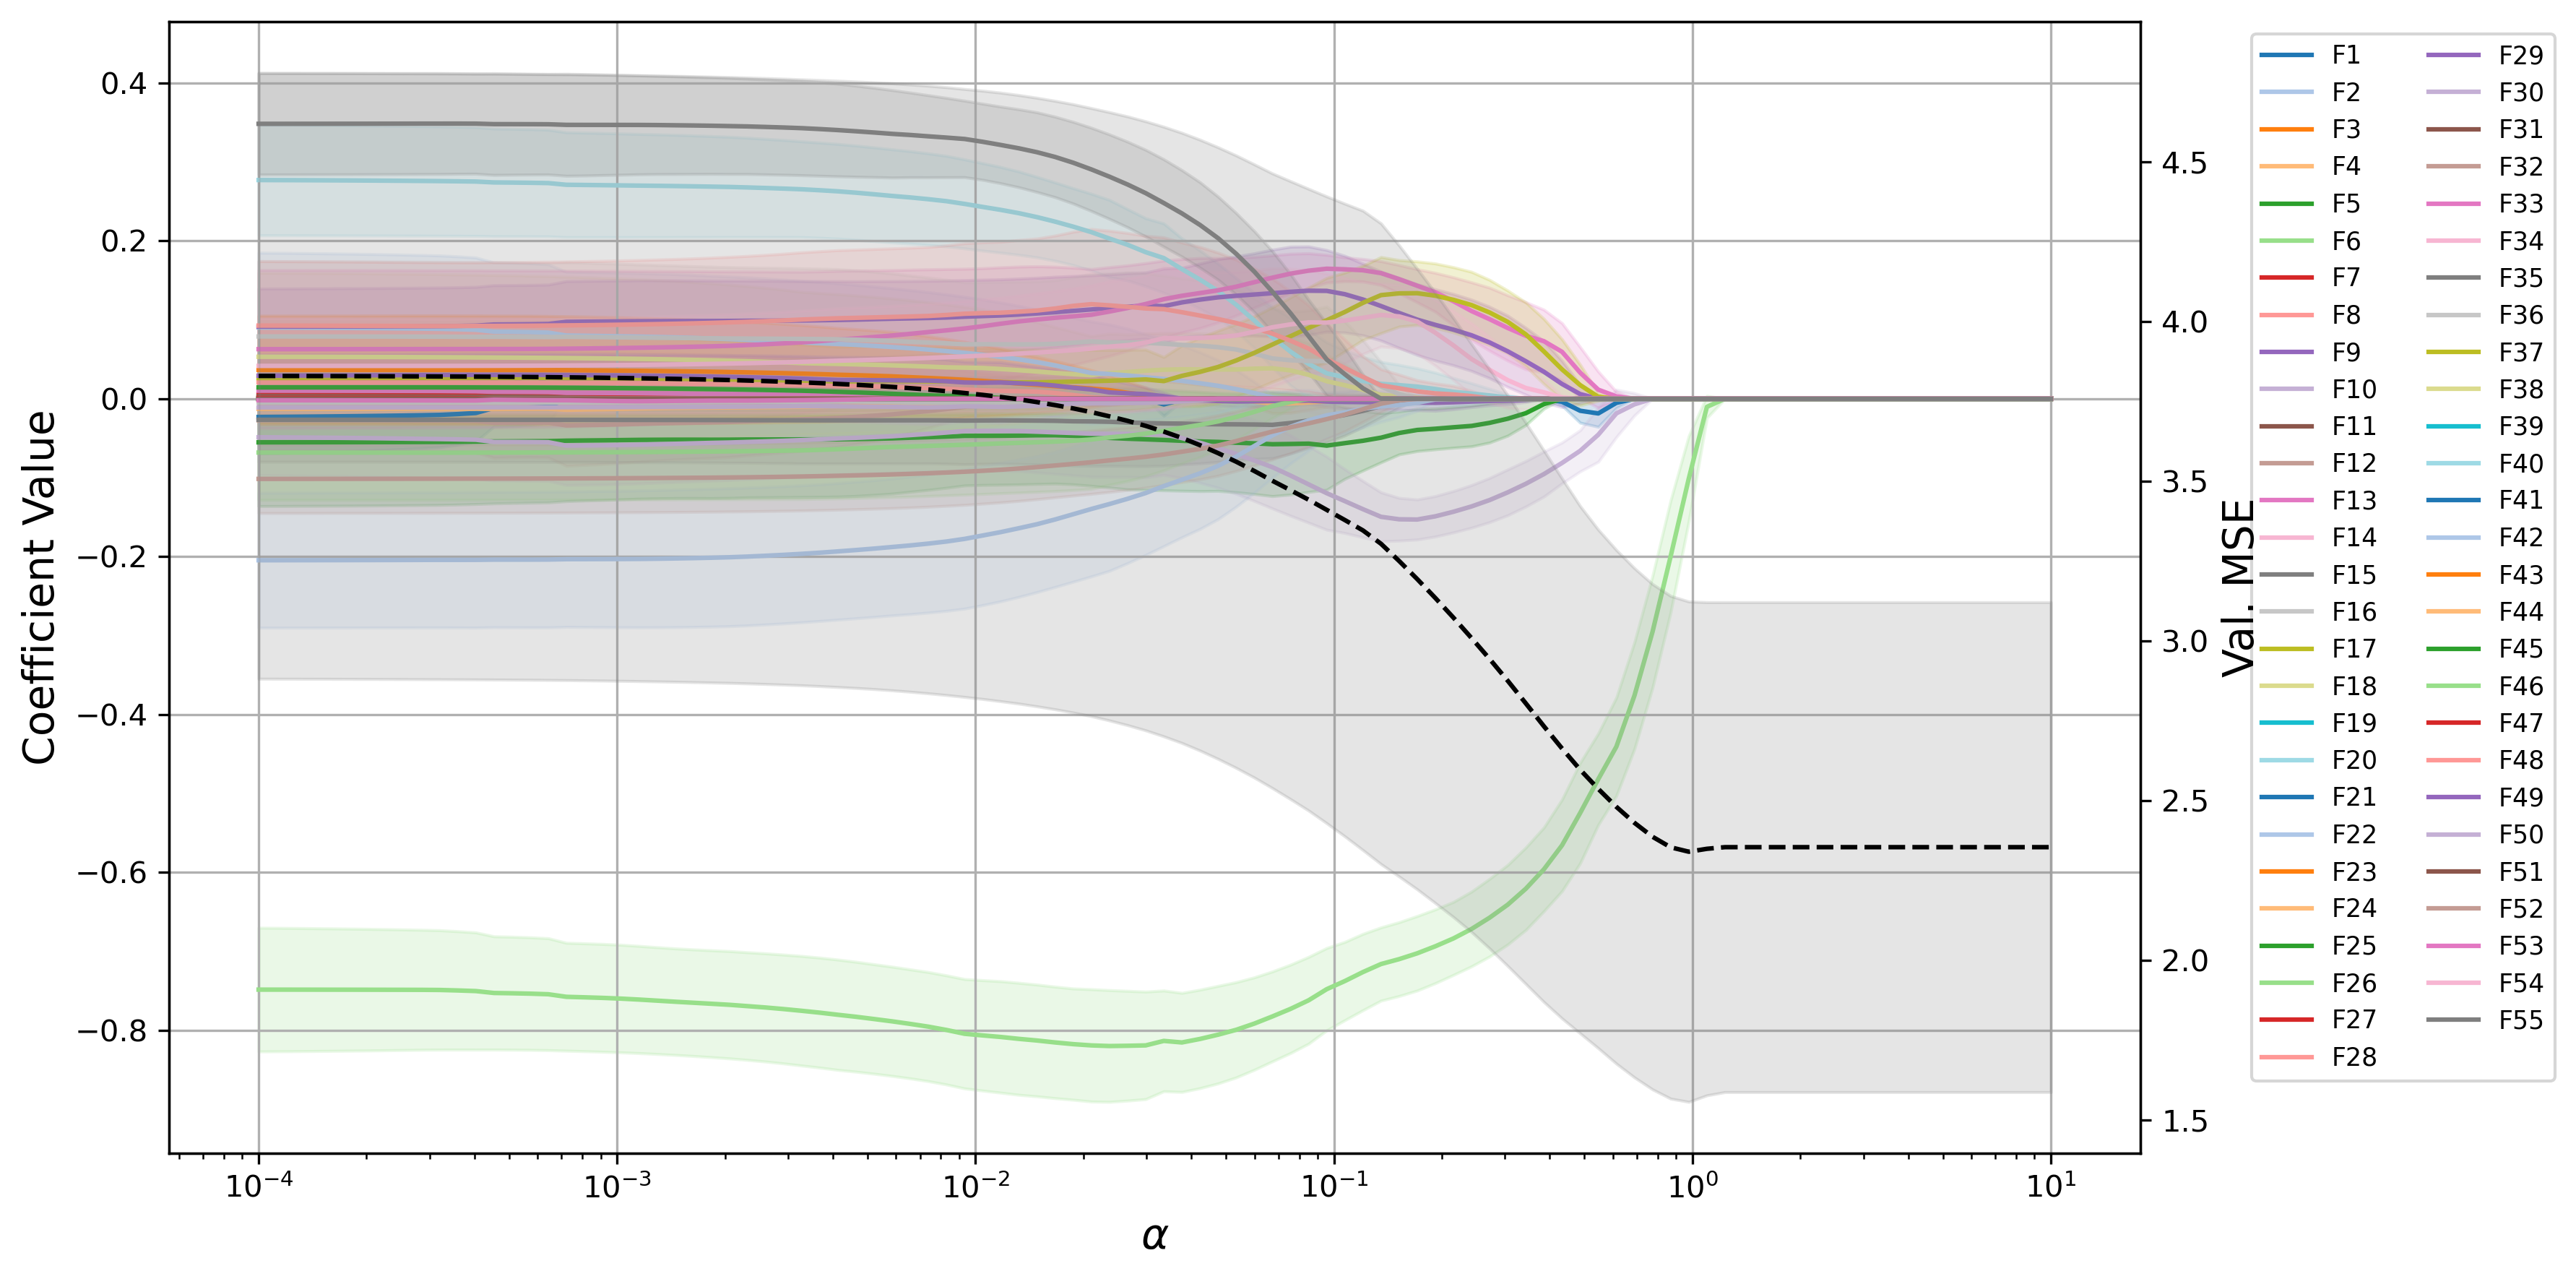

In [106]:
from sklearn.model_selection import KFold

# Define grid of lambda values (alphas in sklearn)
alphas = np.logspace(-4, 1, 100)
n_features = X_fit.shape[1]
y = Y_fit_FEN

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store coefficients for each alpha and each fold
coefficients = np.zeros((len(alphas), n_features, kf.get_n_splits()))
r2_scores = np.zeros((len(alphas), kf.get_n_splits()))
r2_scores_t = np.zeros((len(alphas), kf.get_n_splits()))
MSE = np.zeros((len(alphas), kf.get_n_splits()))
MSE_t = np.zeros((len(alphas), kf.get_n_splits()))
models = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_fit)):
    X_train, y_train = X_fit[train_idx], y[train_idx]
    X_val, y_val = X_fit[val_idx], y[val_idx]
    #scaler_all_FEN = MinMaxScaler()
    scaler_all_FEN = StandardScaler()
    X_train = scaler_all_FEN.fit_transform(X_train)
    X_val = scaler_all_FEN.transform(X_val)
    for j, alpha in enumerate(alphas):
        model = Lasso(alpha=alpha, max_iter=100000)
        model.fit(X_train, y_train)
        coefficients[j, :, i] = model.coef_
        r2_scores[j, i] = model.score(X_val, y_val)
        r2_scores_t[j, i] = model.score(X_train, y_train)
        MSE[j, i] = ((model.predict(X_val)-y_val)**2).mean()
        MSE_t[j, i] = ((model.predict(X_train)-y_train)**2).mean()
        models.append((scaler_all_FEN, model))

# Compute mean and standard deviation of coefficients across folds
mean_coefficients = coefficients.mean(axis=2)
std_coefficients = coefficients.std(axis=2)

# Create a figure and axis using the object-oriented API
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
colors = plt.cm.tab20.colors

# Plot regularization paths with error bars
for k in range(n_features):
    ax.plot(alphas, mean_coefficients[:, k], color=colors[k % len(colors)], label=f"F{k+1}")
    ax.fill_between(
        alphas,
        mean_coefficients[:, k] - std_coefficients[:, k],
        mean_coefficients[:, k] + std_coefficients[:, k],
        alpha=0.2,
        color=colors[k % len(colors)]
    )
ax2 = ax.twinx()
r2_means = r2_scores.mean(axis=1)
r2_stds = r2_scores.std(axis=1)
MSE_means = MSE.mean(axis=1)
MSE_stds = MSE.std(axis=1)
# ax2.plot(alphas, r2_means, "--k")
# ax2.fill_between(
#         alphas,
#         r2_means - r2_stds,
#         r2_means + r2_stds,
#         alpha=0.2,
#         color='grey'
#     )
ax2.plot(alphas, MSE_means, "--k")
ax2.fill_between(
        alphas,
        MSE_means - MSE_stds,
        MSE_means + MSE_stds,
        alpha=0.2,
        color='grey'
    )
ax.grid()
# Customize the plot
ax.set_xscale("log")
ax.set_xlabel(r"$\alpha$", fontsize=14)
ax.set_ylabel("Coefficient Value", fontsize=14)
#ax.set_title("Regularization Path (Averaged Over Folds)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
#ax.set_xlim(0.001, 1)
#ax.set_ylim(-4, 3)
ax.tick_params(axis="both", which='major', labelsize=10)
ax2.tick_params(axis="both", which='major', labelsize=10)
ax2.set_ylabel("Val. MSE", fontsize=14)
#ax2.set_ylim(1, 5)
fig.tight_layout()

# Display the plot
plt.show()



x0: 8
alpha: 0.34304692863149194


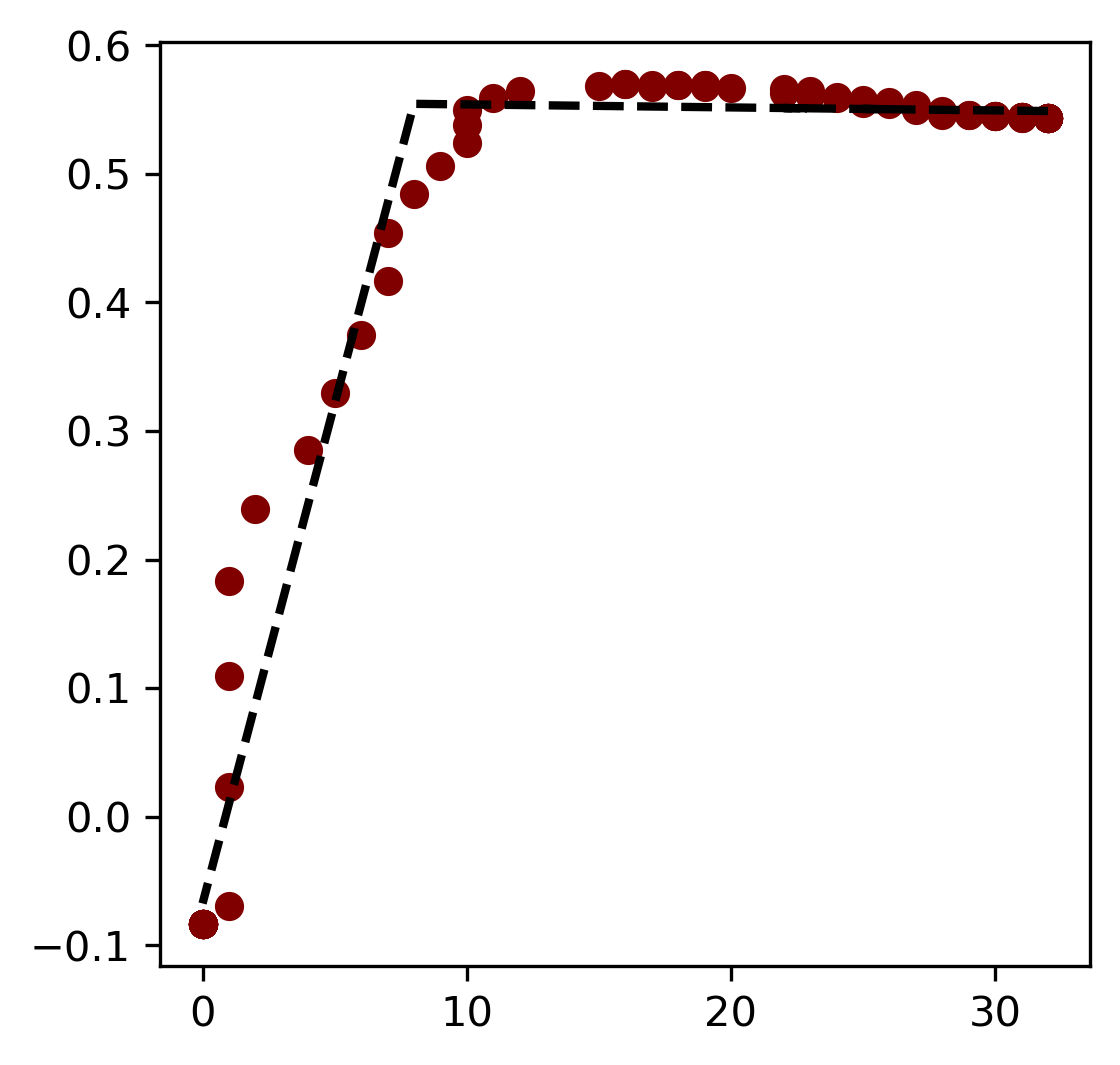

In [107]:
from scipy import optimize

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
#ax.set_xscale("log")
# nnz = []
# r2_clean = []

# for i in range(len(alphas)):
#     nnz_c = len(mean_coefficients[i].nonzero()[0])
#     if nnz_c not in nnz:
#         nnz.append(nnz_c)
#         r2_clean.append(r2_means[i])

# nnz = np.asarray(nnz)
# r2_clean = np.asarray(r2_clean)

nnz = np.asarray([len(mean_coefficients[i].nonzero()[0]) for i in range(len(alphas))])
ax.scatter(nnz, r2_means, color="#800000", label="nnz")

x0ind = 70
x0 = nnz[x0ind]
print(f"x0: {nnz[x0ind]}")
print(f"alpha: {alphas[x0ind]}")

def piecewise_linear(x, c, m1, m2):
    return np.where(x<x0, m1*x + c-m1*x0, m2*x + c-m2*x0)

p, e = optimize.curve_fit(piecewise_linear, nnz, r2_means)
ax.plot(nnz, piecewise_linear(nnz, *p), "--k", lw=2, label="Piece-wise fit")

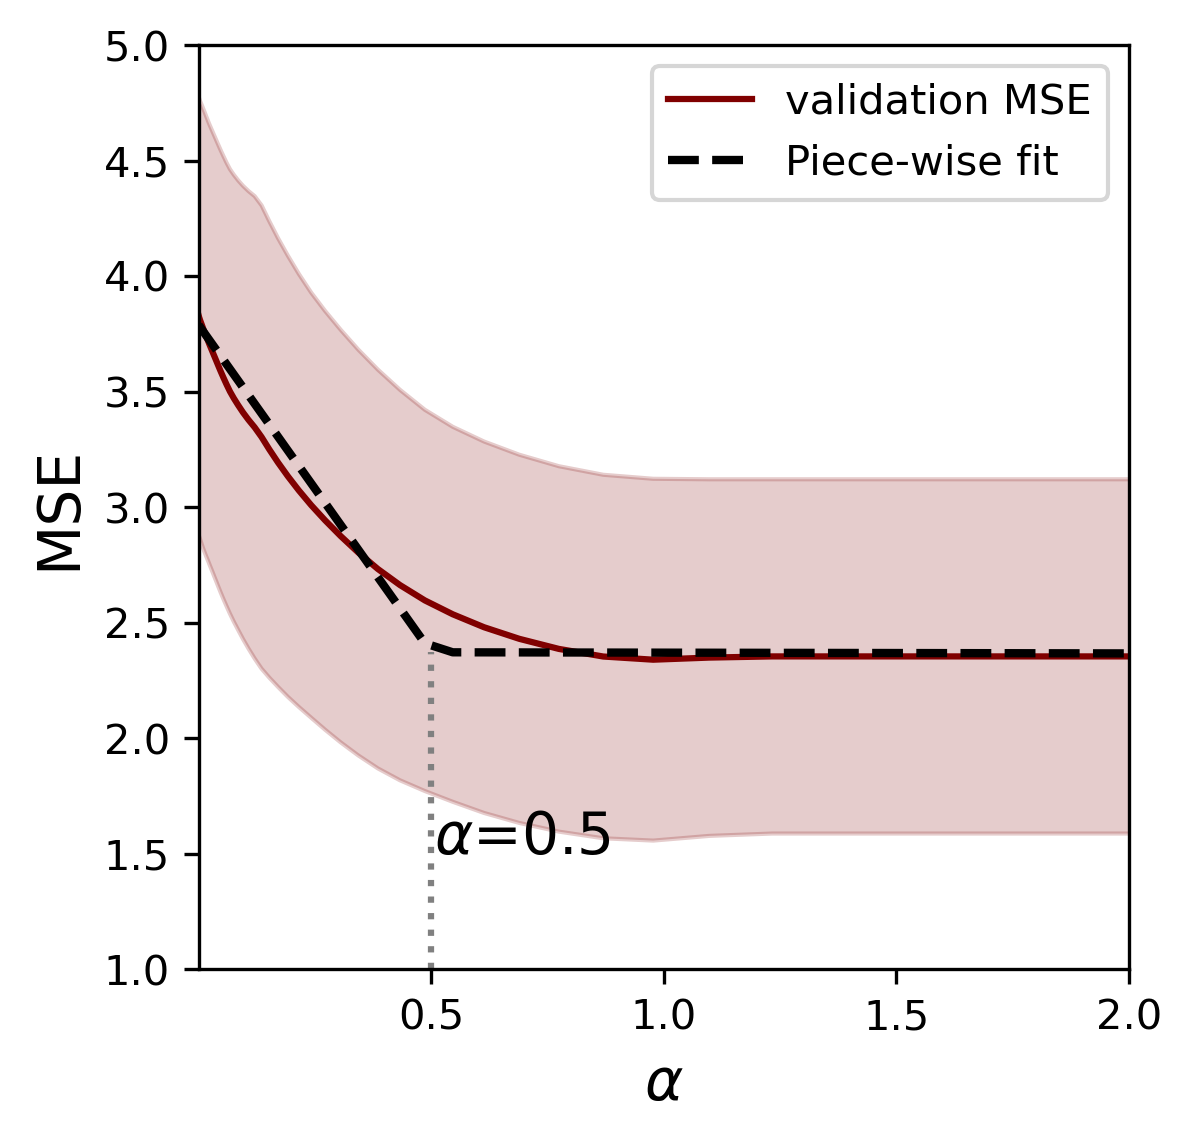

In [105]:
from scipy import optimize

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
#ax.set_xscale("log")
ax.plot(alphas, MSE_means, color="#800000", label="validation MSE")
ax.fill_between(
        alphas,
        MSE_means - MSE_stds,
        MSE_means + MSE_stds,
        alpha=0.2,
        color='#800000'
    )

x0 = 0.5
def piecewise_linear(x, c, m1, m2):
    return np.piecewise(x, [x < x0], [lambda x:m1*x + c-m1*x0, lambda x:m2*x + c-m2*x0])

p, e = optimize.curve_fit(piecewise_linear, alphas, MSE_means)
ax.plot(alphas, piecewise_linear(alphas, *p), "--k", lw=2, label="Piece-wise fit")

ax.vlines(x0, 1.0, piecewise_linear(x0, *p), "gray", linestyles="dotted")

ax.set_xlim(0.001, 2)
ax.set_ylim((1.0, 5.0))
#ax.set_xticks([0.01, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.text(x0+0.005, 1.5, rf"$\alpha$={x0}", fontsize=14)
ax.set_xlabel(r"$\alpha$", fontsize=14)
ax.set_ylabel("MSE", fontsize=14)
ax.legend()


In [91]:
clf_FEN = Lasso(alpha=0.03, max_iter=10000)
scaler_all_FEN = MinMaxScaler()
X_fit_scaled = scaler_all_FEN.fit_transform(X_fit)
clf_FEN.fit(X_fit_scaled, Y_fit_FEN)
print(clf_FEN.score(X_fit_scaled, Y_fit_FEN))

0.6378678200666639


In [92]:
nz_coeffs = clf_FEN.coef_.nonzero()[0]
print("N params: ", len(nz_coeffs))
for i in nz_coeffs:
    print(f"{lasso_data.columns[1:][i]}: {clf_FEN.coef_[i]}")

N params:  8
alpha-CH chemical shifts: -0.3274778114465721
Conformational parameter of beta-turn: -0.007860736116681795
Retention coefficient in TFA: -2.7896525817448405
Negative charge: 0.4706046212936625
AA composition of mt-proteins from animal: 0.8625950904425748
Normalized composition from fungi and plant: -0.7914245324234357
Weights for alpha-helix at the window position of -6: 0.9294703877707735
Linker propensity from 1-linker dataset: 0.7161669227793291


1. Alpha-CH chemical shifts
  * Bagged with many other properties e.g. "Hydrophobicity index", "Hydrophilicity value", "Solvation free energy", and "Volume" 
  * Prefers bulky side chains

2. Retention coefficient in TFA
  * quantifies the contribution of each amino acid residue to the retention of peptides during RP-HPLC. Bagged with other retention time features as well as hydrophobicity and polarity related features.
  * Hydrophobic residues have increased retention times (positive values).

3. Negative charge
  * Bagged with net charge. 
  * Neutral PCCs have better binding free energies.

4. AA composition of mt-proteins from animal
  * Relative abundance of amino acids in mitochondrial proteins encoded by animal mitochondrial DNA. Bagged with Transmembrane regions of mt-proteins.
  * W, Y, and H, that are abundant in our best performers have low values.

5. Normalized composition from fungi and plant
  * relative abundance of amino acids in mitochondrial proteins from fungi and plants. No bag.
  * W is relatively abundant in fungi and plant mt proteins.

6. Weights for alpha-helix at the window position of -6
  * Quantifies how strongly the amino acid located six residues upstream (N-terminal side) of the central residue in a sliding window contributes to alpha-helix formation. Bagged with Weights for alpha-helix at the window position of -4.
  * Bulky residues like W, Y, and H have negative weights and disrupt alpha-helix formation.

7. Linker propensity from 1-linker dataset
  * Quantifies the likelihood of amino acids occurring in short linker regions. No bag.
  * Bulky residues like W, Y, H are less likely to be present in short linker regions.

(-12.0, -4.0)

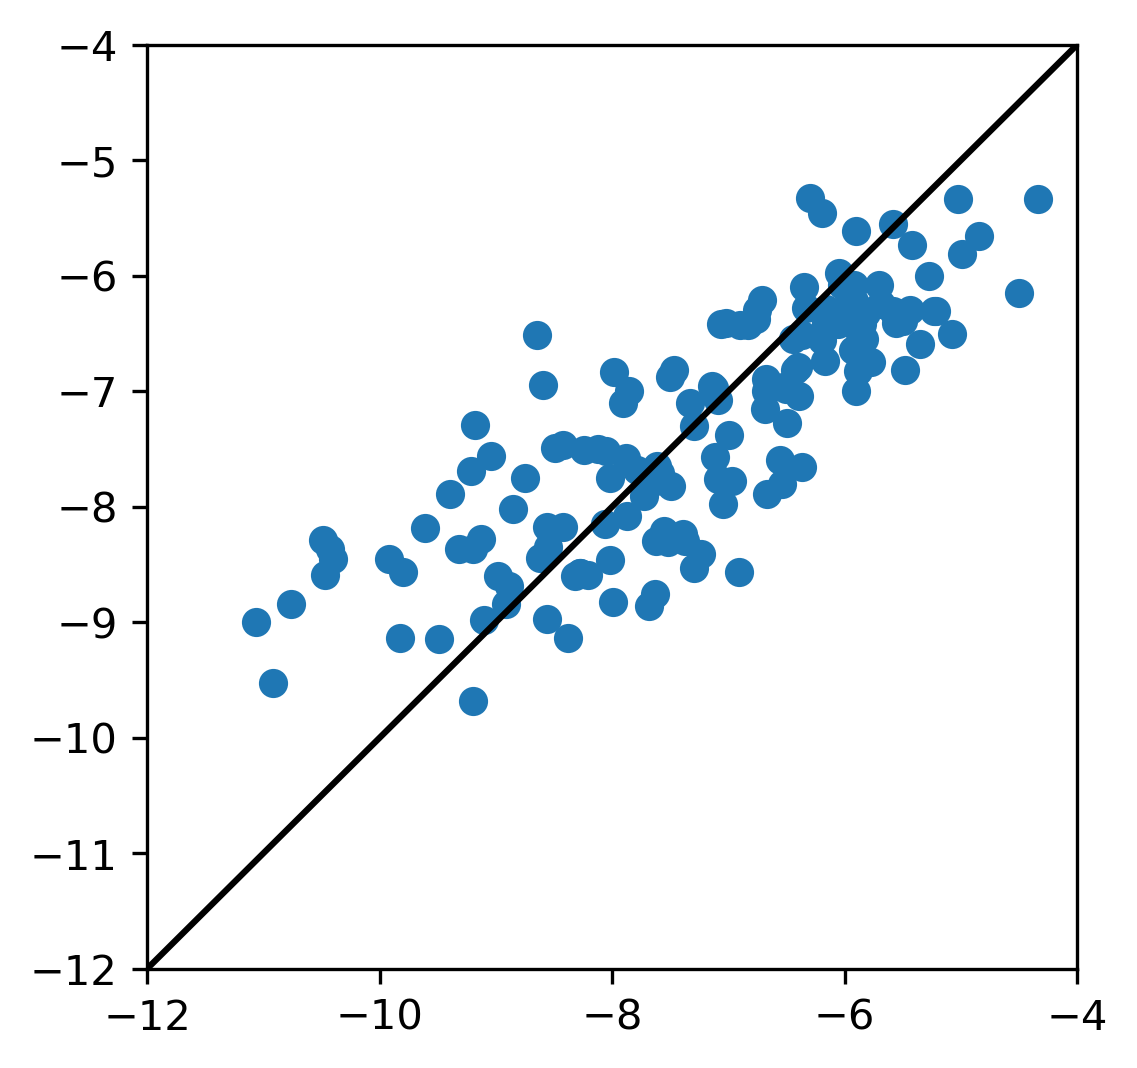

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
y_preds = clf_FEN.predict(X_fit_scaled)
ax.scatter(Y_fit_FEN, y_preds)
ax.plot([-12, -4], [-12, -4], 'k')
ax.set_ylim(-12, -4)
ax.set_xlim(-12, -4)

In [ ]:
# all_feats = []
# for coeffs in coeffs_vals:
#     all_feats.extend(coeffs.nonzero()[0])
# #all_feats.append(28)
# all_feats = np.unique(all_feats)

# coeffs_distilled = []
# for coeffs in coeffs_vals:
#     coeff = []
#     for i in all_feats:
#         coeff.append(coeffs[i])
#     coeffs_distilled.append(coeff)

# coeffs_distilled = np.asarray(coeffs_distilled)

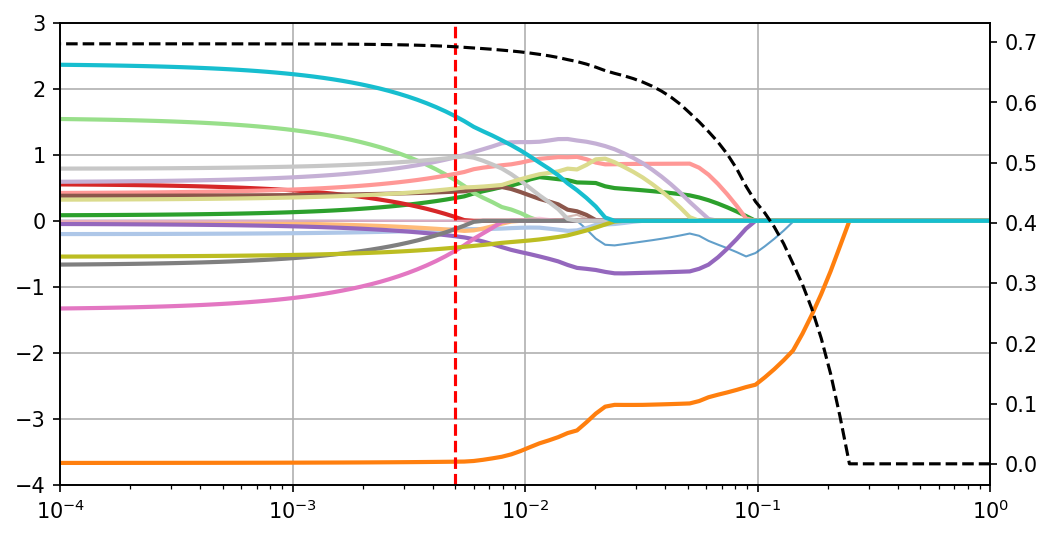

In [31]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
# colors = plt.cm.tab20.colors


# for i in range(coeffs_distilled.shape[1]):
#     if all_feats[i] in nz_coeffs:
#         lw = 2
#         ax.plot(alpha_list, coeffs_distilled[:, i], lw=lw, color=colors[i % len(colors)])
#     else:
#         lw = 1
#         ax.plot(alpha_list, coeffs_distilled[:, i], lw=lw, alpha=0.7, color=colors[i % len(colors)])
# ax2 = ax.twinx()
# ax2.plot(alpha_list, RMSE_list, "--k")
# ax.vlines(0.005, -4, 3, "red", "dashed")
# ax.set_xscale("log")
# ax.grid()
# ax.set_xlim(0.0001, 1)
# ax.set_ylim(-4, 3)
# plt.show()

In [36]:
col_idx = [i+1 for i in nz_coeffs]
fitted_lasso = lasso_data.loc[:, lasso_data.columns[col_idx]]

In [37]:
s_corr = fitted_lasso.corr(method="spearman")
p_corr = fitted_lasso.corr(method="pearson")

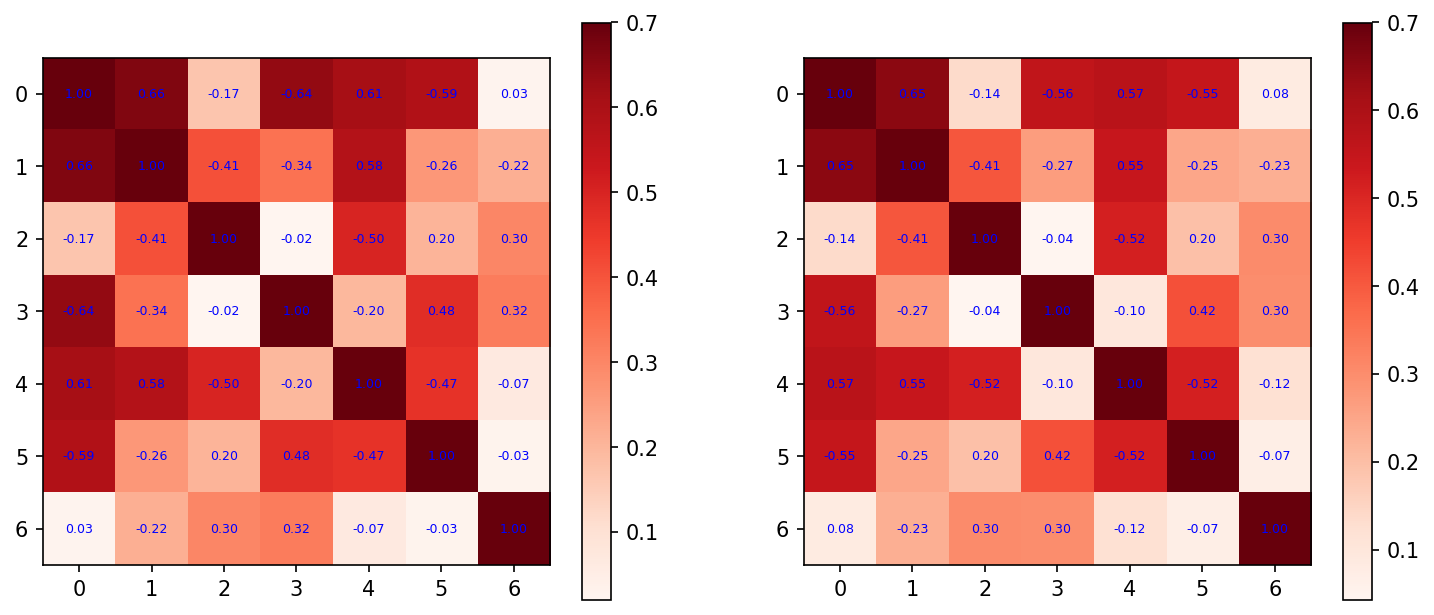

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
im0 = axs[0].imshow(abs(s_corr.values), cmap="Reds", vmax=0.7)
fig.colorbar(im0, ax=axs[0])
for i in range(s_corr.values.shape[0]):
    for j in range(s_corr.values.shape[1]):
        axs[0].text(j, i, f"{s_corr.values[i, j]:.2f}", ha='center', va='center', color='blue', fontsize=6)

im1 = axs[1].imshow(abs(p_corr.values), cmap="Reds", vmax=0.7)
fig.colorbar(im1, ax=axs[1])
for i in range(p_corr.values.shape[0]):
    for j in range(p_corr.values.shape[1]):
        axs[1].text(j, i, f"{p_corr.values[i, j]:.2f}", ha='center', va='center', color='blue', fontsize=6)

plt.show()

In [28]:
for i, ind in enumerate(nz_coeffs):
    print(f"{i}: {lasso_data.columns[1:][ind]}")

0: alpha-CH chemical shifts
1: Retention coefficient in TFA
2: Negative charge
3: AA composition of mt-proteins from animal
4: Normalized composition from fungi and plant
5: Weights for alpha-helix at the window position of -6
6: Linker propensity from 1-linker dataset


# FEN (ElasticNet)

In [98]:
def get_alpha_score(X, Y, alpha):
    scaler = MinMaxScaler()
    lasso = ElasticNet(alpha=alpha, max_iter=10000, l1_ratio=0.99)

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', scaler),  # Step 1: Scale data
        ('model', lasso)     # Step 2: Fit the model
    ])

    # Perform cross-validation
    scores = cross_val_score(pipeline, X, Y, cv=5, scoring="r2")

    # Output results
    return scores.mean()

In [99]:
alpha_list =alpha_list = 10 ** (-np.linspace(0, 4, 100))
r2_scores = []

for alpha in alpha_list:
    r2_scores.append(get_alpha_score(X_fit, Y_fit_FEN, alpha=alpha))

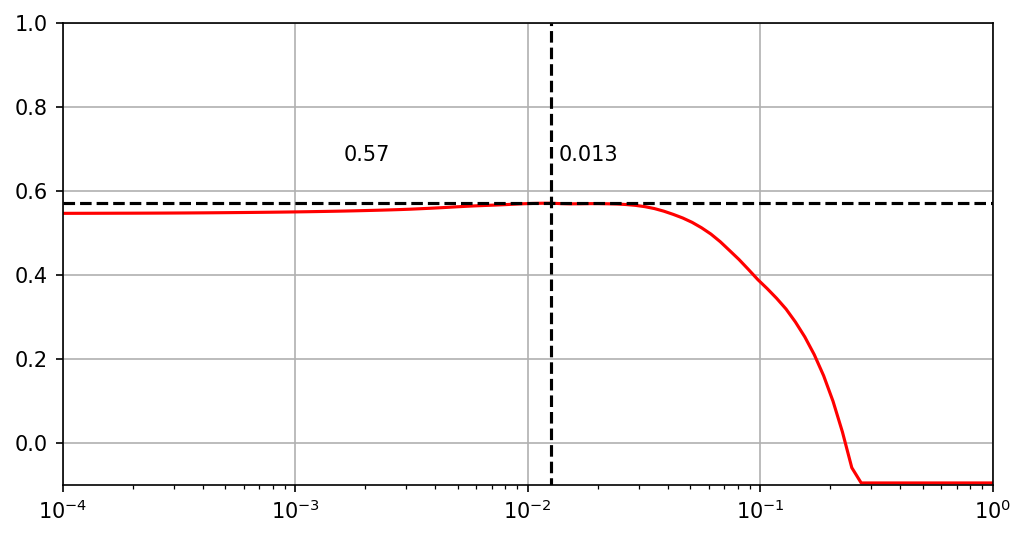

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)

ax.plot(alpha_list, r2_scores, "r")
ax.set_xscale("log")
ax.grid()
ax.set_xlim(0.0001, 1)
ax.set_ylim(-0.1, 1)
ax.hlines(np.max(r2_scores), 0.0001, 1, 'black', 'dashed')
ax.text(alpha_list[np.argmax(r2_scores)]-0.011, np.max(r2_scores)+0.1, f"{np.max(r2_scores):.2f}")
ax.vlines(alpha_list[np.argmax(r2_scores)], -1, 1, 'black', 'dashed')
ax.text(alpha_list[np.argmax(r2_scores)]+0.001, np.max(r2_scores)+0.1, f"{alpha_list[np.argmax(r2_scores)]:.4f}")
plt.show()

In [82]:
clf_FEN = ElasticNet(alpha=0.0115, max_iter=10000, l1_ratio=1)
scaler_all_FEN = MinMaxScaler()
clf_FEN.fit(scaler_all_FEN.fit_transform(X_fit), Y_fit_FEN)

ElasticNet(alpha=0.0115, l1_ratio=1, max_iter=10000)

In [83]:
nz_coeffs = clf_FEN.coef_.nonzero()[0]
print("N params: ", len(nz_coeffs))
for i in nz_coeffs:
    print(f"{lasso_data.columns[1:][i]}: {clf_FEN.coef_[i]}")

N params:  12
Conformational parameter of beta-turn: -0.10380585108265812
Retention coefficient in TFA: -3.3716836639139234
Negative charge: 0.6621314981597819
AA composition of mt-proteins from animal: 0.9397779099474375
Normalized composition from fungi and plant: -0.5395249523299257
Weights for alpha-helix at the window position of -6: 1.1981189399775354
Weights for coil at the window position of 4: 0.3326724321666019
Free energy change of epsilo: 0.047452709249223624
Normalized positional residue frequency at helix termini N5: 0.3848917527819037
Side-chain conformation by gaussian evolutionary method: -0.2823135443083575
Linker propensity from 1-linker dataset: 0.7053072280376171
Linker propensity from small dataset: 0.8822116655819102


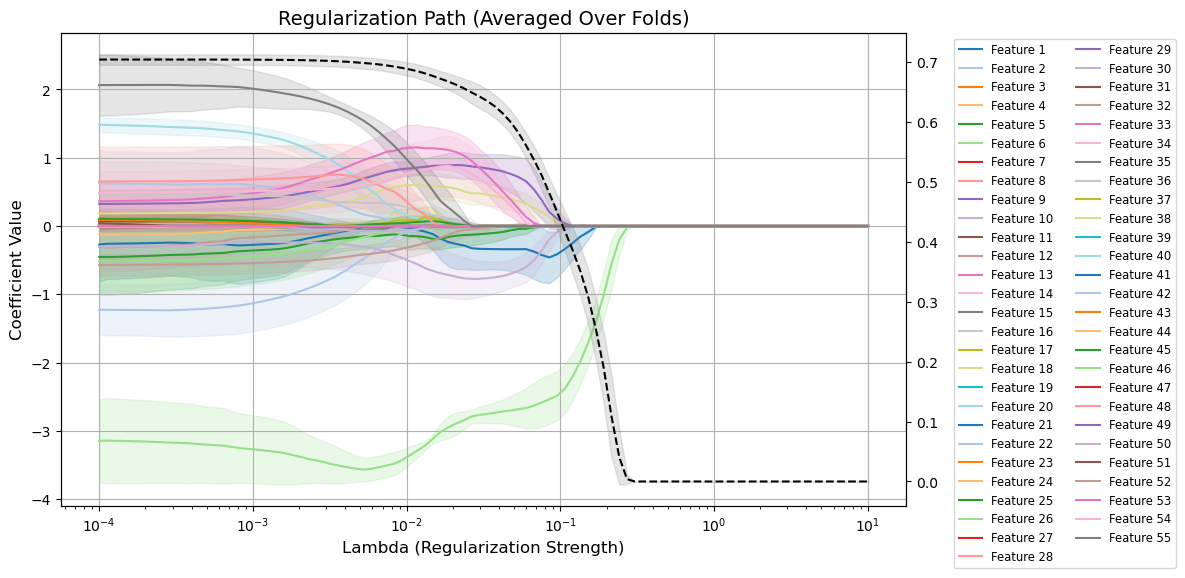